<a href="https://colab.research.google.com/github/KelseyNager/GenAI/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoders on the SVHN Dataset

###Kelsey Nager
###CSC 330
###The goal of this assignment is create and train a Variational Autoencoder model in Keras to learn representations of the Street View House Numbers dataset and explore its performance with different latent dimensions.

# Load and Preprocess Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, losses, metrics, optimizers
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm
from scipy.io import loadmat

In [ ]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2024-10-22 00:04:35--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  10.2MB/s    in 15s     

2024-10-22 00:04:50 (11.3 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2024-10-22 00:04:50--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  3.10MB/s    in 14s     

2024-10-22 00:05:04 (4.50 MB/s) - ‘test_32x32.mat’ saved [64275384/64

#Load and Pre-Processing

In [ ]:
# Load data
train_data = loadmat('train_32x32.mat')
test_data = loadmat('test_32x32.mat')

# Preprocess the data
x_train = np.transpose(train_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_train = train_data['y'].flatten()
x_test = np.transpose(test_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_test = test_data['y'].flatten()

# Display the shape of the datasets
print(f'Training data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

Training data shape: (73257, 32, 32, 3)
Test data shape: (26032, 32, 32, 3)


# Build VAE





In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Encoder
encoder_input = layers.Input(
    shape=(32, 32, 3), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
z_mean = layers.Dense(2, name="z_mean")(x)
z_log_var = layers.Dense(2, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_1[0][0]']            
                                                                                            

In [ ]:
# Decoder

decoder_input = layers.Input(shape=(2,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    3,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        18464 

In [ ]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                500
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            500
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [ ]:
# Create a variational autoencoder
def build_vae(latent_dim):
    return VAE(encoder, decoder)


# Training the model with different latent dimensions

In [ ]:
latent_dims = [2]
for dim in latent_dims:
  print(f'Training VAE with latent dimension: {dim}')
  vae = build_vae(latent_dim=dim)
  vae.compile(optimizer='adam', loss=losses.binary_crossentropy)
  vae.fit(x_train, epochs=1, batch_size=32, validation_data=(x_test, x_test))

Training VAE with latent dimension: 2


KeyboardInterrupt: 

In [ ]:
latent_dims = [2, 5, 10]
for dim in latent_dims:
  print(f'Training VAE with latent dimension: {dim}')
  vae = build_vae(latent_dim=dim)
  vae.compile(optimizer='adam', loss=losses.binary_crossentropy)
  vae.fit(x_train, epochs=50, batch_size=128, validation_data=(x_test, x_test))

Training VAE with latent dimension: 2
Epoch 1/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 344s 589ms/step - kl_loss: 1.4570 - reconstruction_loss: 331.8543 - total_loss: 333.3114 - val_kl_loss: 2.9850 - val_loss: 316.1911 - val_reconstruction_loss: 313.2061
Epoch 2/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 378s 583ms/step - kl_loss: 2.7645 - reconstruction_loss: 318.5372 - total_loss: 321.3018 - val_kl_loss: 2.9139 - val_loss: 316.1509 - val_reconstruction_loss: 313.2370
Epoch 3/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 381s 582ms/step - kl_loss: 2.7888 - reconstruction_loss: 318.3430 - total_loss: 321.1318 - val_kl_loss: 2.8859 - val_loss: 316.3890 - val_reconstruction_loss: 313.5031
Epoch 4/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 384s 585ms/step - kl_loss: 2.8221 - reconstruction_loss: 318.0576 - total_loss: 320.8797 - val_kl_loss: 2.9045 - val_loss: 316.3755 - val_reconstruction_loss: 313.4711
Epoch 5/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 378s 578ms/step - kl_loss: 2.8077 - reconstruction_loss: 318.1945 - total_loss: 321.0021 -

Reconstructing using variational autoencoder

In [ ]:
latent_dims = [2, 5, 10]
for dim in latent_dims:
  print(f'Training VAE with latent dimension: {dim}')
  vae = build_vae(latent_dim=dim)
  vae.compile(optimizer='adam', loss=losses.binary_crossentropy)
  vae.fit(x_train, epochs=100, batch_size=128, validation_data=(x_test, x_test))

Training VAE with latent dimension: 2
Epoch 1/100
573/573 [==============================] - 31s 52ms/step - total_loss: 320.7397 - reconstruction_loss: 317.8123 - kl_loss: 2.9276 - val_loss: 315.8227 - val_reconstruction_loss: 312.7326 - val_kl_loss: 3.0901
Epoch 2/100
573/573 [==============================] - 29s 51ms/step - total_loss: 320.7166 - reconstruction_loss: 317.7722 - kl_loss: 2.9443 - val_loss: 316.8002 - val_reconstruction_loss: 313.7385 - val_kl_loss: 3.0617
Epoch 3/100
573/573 [==============================] - 29s 51ms/step - total_loss: 320.7170 - reconstruction_loss: 317.7689 - kl_loss: 2.9482 - val_loss: 316.3322 - val_reconstruction_loss: 313.3861 - val_kl_loss: 2.9461
Epoch 4/100
573/573 [==============================] - 29s 51ms/step - total_loss: 320.6906 - reconstruction_loss: 317.7469 - kl_loss: 2.9437 - val_loss: 316.1645 - val_reconstruction_loss: 312.8995 - val_kl_loss: 3.2650
Epoch 5/100
573/573 [==============================] - 29s 50ms/step - total_l

In [ ]:
latent_dims = [2, 5, 10]
for dim in latent_dims:
  print(f'Training VAE with latent dimension: {dim}')
  vae = build_vae(latent_dim=dim)
  vae.compile(optimizer='adam', loss=losses.binary_crossentropy)
  vae.fit(x_train, epochs=100, batch_size=64, validation_data=(x_test, x_test))

Training VAE with latent dimension: 2
Epoch 1/100
1145/1145 [==============================] - 41s 34ms/step - total_loss: 325.4273 - reconstruction_loss: 323.1266 - kl_loss: 2.3007 - val_loss: 316.0189 - val_reconstruction_loss: 313.2160 - val_kl_loss: 2.8029
Epoch 2/100
1145/1145 [==============================] - 38s 33ms/step - total_loss: 321.0886 - reconstruction_loss: 318.2843 - kl_loss: 2.8039 - val_loss: 316.4308 - val_reconstruction_loss: 313.5172 - val_kl_loss: 2.9136
Epoch 3/100
1145/1145 [==============================] - 37s 33ms/step - total_loss: 321.0021 - reconstruction_loss: 318.1861 - kl_loss: 2.8160 - val_loss: 316.2488 - val_reconstruction_loss: 313.1709 - val_kl_loss: 3.0779
Epoch 4/100
1145/1145 [==============================] - 38s 33ms/step - total_loss: 320.9718 - reconstruction_loss: 318.1488 - kl_loss: 2.8227 - val_loss: 316.4676 - val_reconstruction_loss: 313.5135 - val_kl_loss: 2.9542
Epoch 5/100
1145/1145 [==============================] - 38s 33ms/step

# Generation and Visualization

In [ ]:
# Select a subset of the test set
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [ ]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real house numbers")
display(example_images)
print("Reconstructions")
display(reconstructions)

157/157 [==============================] - 1s 8ms/step
Example real house numbers


array([[[[0.14901961, 0.40392157, 0.23529412],
         [0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.24313726],
         ...,
         [0.16078432, 0.4       , 0.23921569],
         [0.16470589, 0.40392157, 0.24313726],
         [0.15294118, 0.38039216, 0.22352941]],

        [[0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.24313726],
         ...,
         [0.16078432, 0.4       , 0.23921569],
         [0.16862746, 0.39607844, 0.24705882],
         [0.15294118, 0.38039216, 0.22352941]],

        [[0.14901961, 0.4117647 , 0.24313726],
         [0.14509805, 0.40784314, 0.23921569],
         [0.15294118, 0.41568628, 0.24705882],
         ...,
         [0.16862746, 0.39607844, 0.24705882],
         [0.16862746, 0.39215687, 0.2509804 ],
         [0.15294118, 0.38039216, 0.23137255]],

        ...,

        [[0.20392157, 0.46666667, 0.30588236],
         [0.20784314, 0.47058824, 0.30980393]

Reconstructions


array([[[[0.2650102 , 0.2662759 , 0.28026414],
         [0.2597175 , 0.2617533 , 0.2761247 ],
         [0.25863507, 0.25925878, 0.27415633],
         ...,
         [0.22665921, 0.2291081 , 0.24799089],
         [0.23118865, 0.23242164, 0.24869516],
         [0.22948529, 0.22759958, 0.24374229]],

        [[0.26511922, 0.26996425, 0.28370747],
         [0.26339185, 0.26902425, 0.2835351 ],
         [0.26151237, 0.2646749 , 0.27940035],
         ...,
         [0.22385429, 0.22903085, 0.24881433],
         [0.2272083 , 0.23131114, 0.24809119],
         [0.23197195, 0.23356767, 0.24920815]],

        [[0.27502942, 0.27904478, 0.29065728],
         [0.27498737, 0.28167754, 0.29450735],
         [0.26694342, 0.27102318, 0.2867396 ],
         ...,
         [0.22357471, 0.22928613, 0.25039846],
         [0.22834982, 0.23388648, 0.25244197],
         [0.23199123, 0.23254186, 0.24663611]],

        ...,

        [[0.28781635, 0.29179776, 0.31754243],
         [0.28524062, 0.29432312, 0.31862432]

In [ ]:

# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)

157/157 [==============================] - 1s 3ms/step


In [ ]:
# Some examples of the embeddings
print(z[:10])

[[-1.3002795  -0.35559273]
 [ 1.1074595   0.92047036]
 [ 0.8220828  -0.19222715]
 [ 0.8053851  -0.2591804 ]
 [ 0.8778645  -0.5994113 ]
 [-0.39561415  0.38496834]
 [-3.3363068  -1.8279724 ]
 [-1.1606998  -2.915196  ]
 [ 1.0426984   0.6423055 ]
 [ 0.6631469  -0.01861425]]


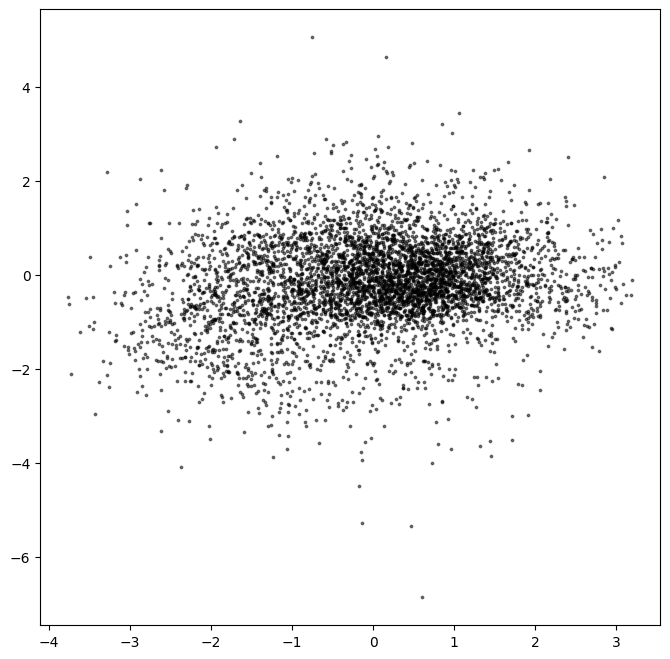

In [ ]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

In [ ]:
# Sample some points in the latent space
grid_width, grid_height = (8, 1)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [ ]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 103ms/step


In [ ]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

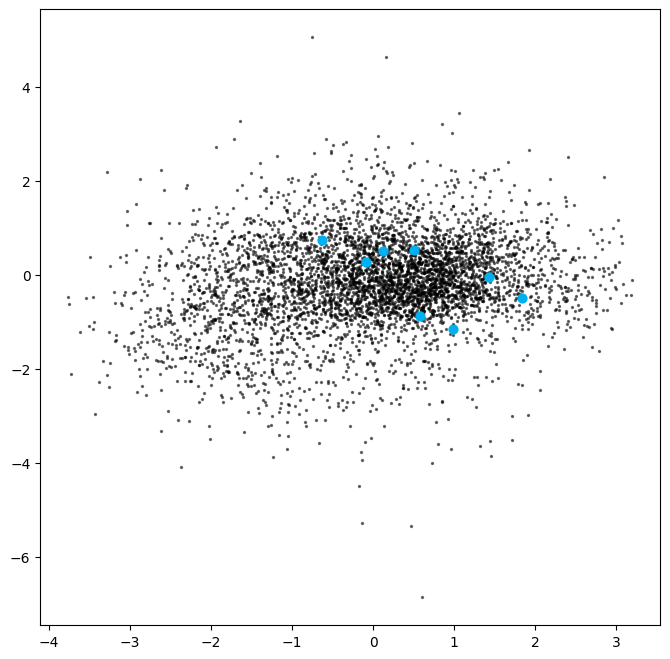

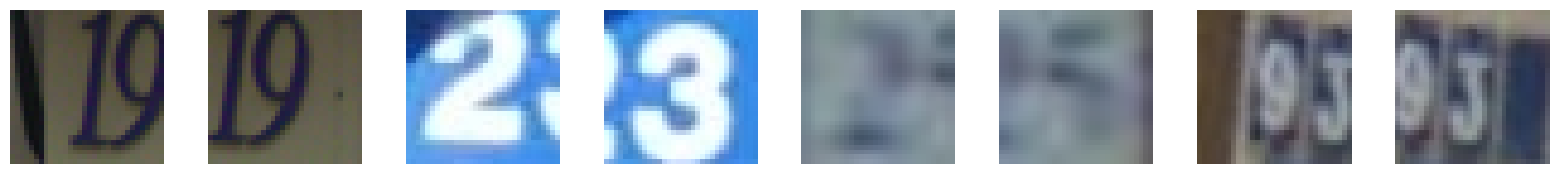

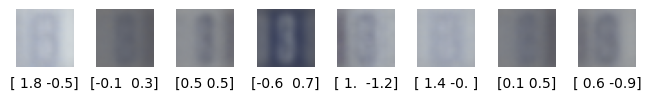

In [ ]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

#Add a line of a sample of original images
fig, axes = plt.subplots(1, 8, figsize=(20, 2))
for i in range(8):
  axes[i].imshow(x_train[i])
  axes[i].axis('off')
plt.show()

# Add a line of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="viridis")

# Explore Latent Space

In [ ]:
# Colour the embeddings by their label
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

In [ ]:
# Colour the embeddings by their label
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="rainbow")